In [1]:
# Imports
import numpy as np

In [2]:
## User-params
denPts = 3  #No. of density samples for training
xymax = 5   #max x & y coordinates
H = 200 #No. of gradient samples for training
N = 50 #Grid dimensions for original grid and also used for testing grid (Xnew)
subset = 2 #If uniform sampling for training, use this subset

# Enforce minimum spacing between randomly sampled points
# min_spacing = 0.175*2.35  #H=100 points
min_spacing = 0.175*1.6 #H=200 points
# min_spacing = 0.175*1.1   #H=250 points
# min_spacing = 0.175*1.5   #H=300 points

Generate image grid

In [3]:
%load_ext autoreload
%autoreload 2
from Case1helper import analytical

# Initialise analytical case
case = analytical(randseed=2)

# Create uniform image grid for function evaluation
Xo, Yo, Xorig = case.create_grid(xmax=xymax, ymax=xymax, N=N)

Define sample density function, and its gradients

In [4]:
@np.vectorize
def func1(x, y):
    f = np.sin(x**2) * (2*y - 3)/10 + 1.5
    df_dx = x*np.cos(x**2)*(2*y - 3)/5
    df_dy = np.sin(x**2)/5
    return f, df_dx, df_dy

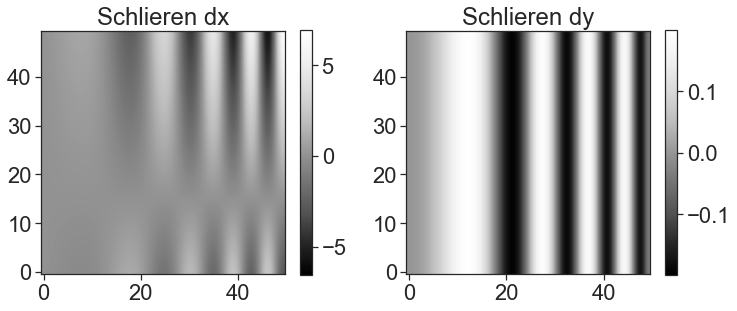

In [5]:
# Evaluate function across grid
# And, normalise grads to 0-255 standard range
density, sch_dx, sch_dy = case.func_eval(func1, normalise=True)

# Store true grad vals
sch_dx_true, sch_dy_true = case.get_true_grads()

# Plot true gradients
case.plot_true_grads()

No. of training points: 200


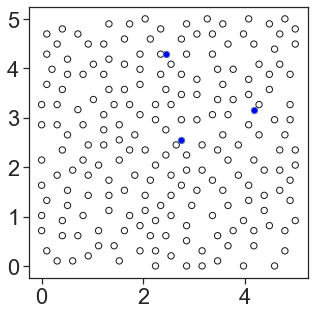

In [6]:
# Get random points for gradient training
# Ms, us, d = case.gen_subsample_pts(step=subset)    # Subsample original grid
Ms, us, d = case.gen_ran_pts(H=H, min_spacing=min_spacing)    # Random sampling of original grid

# Get random density values for training
X_f, f = case.get_ran_density(npts=denPts)

case.plot_sampling_pts()

# Gradient Enhanced Kriging
__________________

# Using Gradient-Based Kriging (Input dx and dy)
___

In [7]:
import pymc3 as pm
import schlierenPymc3 as spm
import theano.tensor as tt

sigma_y, sigma_dy = 1E-4, 1E-1

with pm.Model() as model:
    # Define hyperparameters
    bx = by = c = 0.0

    ls = pm.HalfNormal("ls", sigma=2, shape=2)
    lamda = pm.HalfNormal("lamda", sigma=1, shape=2)

    alphas = tt.stack([lamda[0] * lamda[1]/tt.square(ls[0]) , \
                         lamda[1] * lamda[0]/tt.square(ls[1])])

    xi = pm.HalfNormal("xi", sigma=1)
    sigma_f =  tt.sqrt(xi/(lamda[0] * lamda[1]))

    data = np.r_[
                us[:, 0] - np.average(us[:, 0]), \
                us[:, 1] - np.average(us[:, 1]), 
                f.ravel() - np.average(f)
                ]

    print("No. of function values: ", len(X_f))
    print("No. of gradient values: ", len(Ms))
    print("Data length: ", len(data))
    
    mean_func = spm.gp.mean.SchlierenNorm(bx=bx, by=by, c=c)
    cov_gek = spm.gp.cov.NormGEK(input_dim=2, ls=ls, \
                                 sigma_f=sigma_f, alphas=alphas)
    gp = spm.gp.MarginalNormGEK(mean_func=mean_func, cov_func=cov_gek)
    y_ = gp.marginal_likelihood("y_",
                                X=X_f,  #Function value locations
                                X_df=Ms,  #Gradient value locations
                                y=data,
                                noise_y=sigma_y,    #Input function noise
                                noise_dy=sigma_dy)  #Input gradient noise

No. of function values:  3
No. of gradient values:  200
Data length:  403


In [8]:
# Define hyperparam optimisation method
optmethod = "map" #Options: "MAP", "ADVI", "MCMC"

In [9]:
# Inference
mu_s, cov_s = case.infer(model=model, gp=gp, method=optmethod)


{'ls_log__': array([ 1.63887814, -0.12401175]), 'lamda_log__': array([3.13191549, 3.13191549]), 'xi_log__': array(2.58659224), 'ls': array([5.1493894 , 0.88336946]), 'lamda': array([22.91783643, 22.91783643]), 'xi': array(13.2844243)}


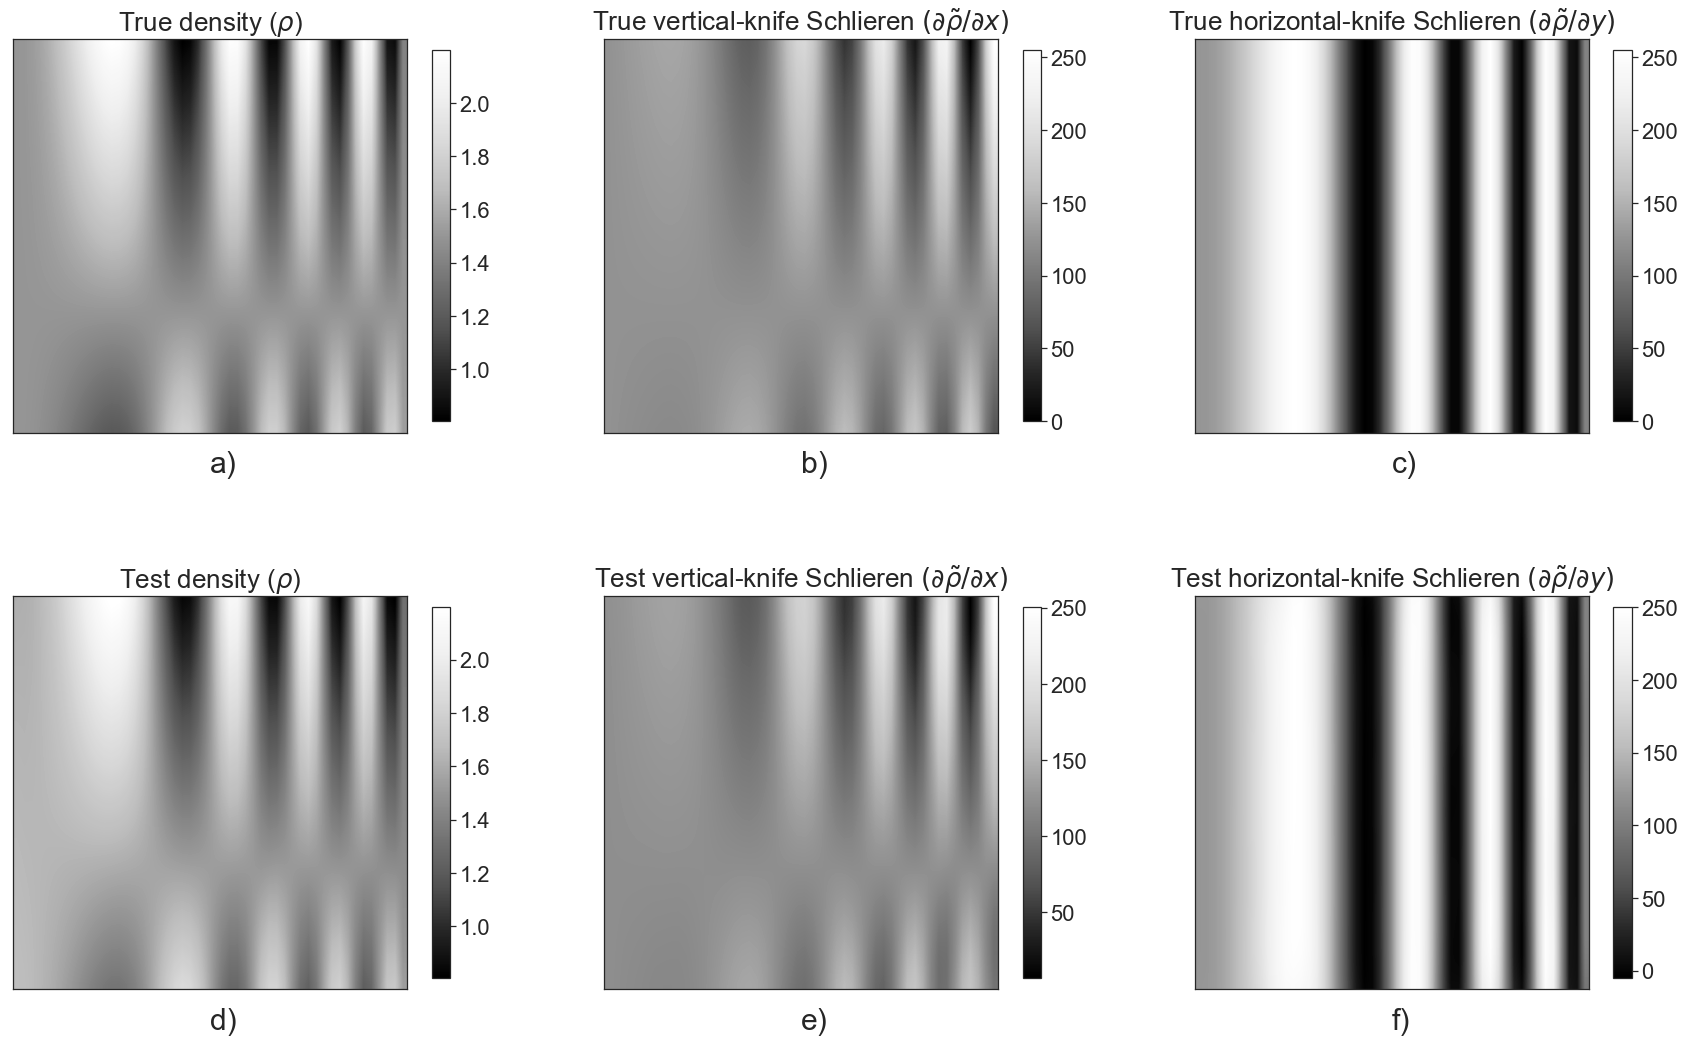

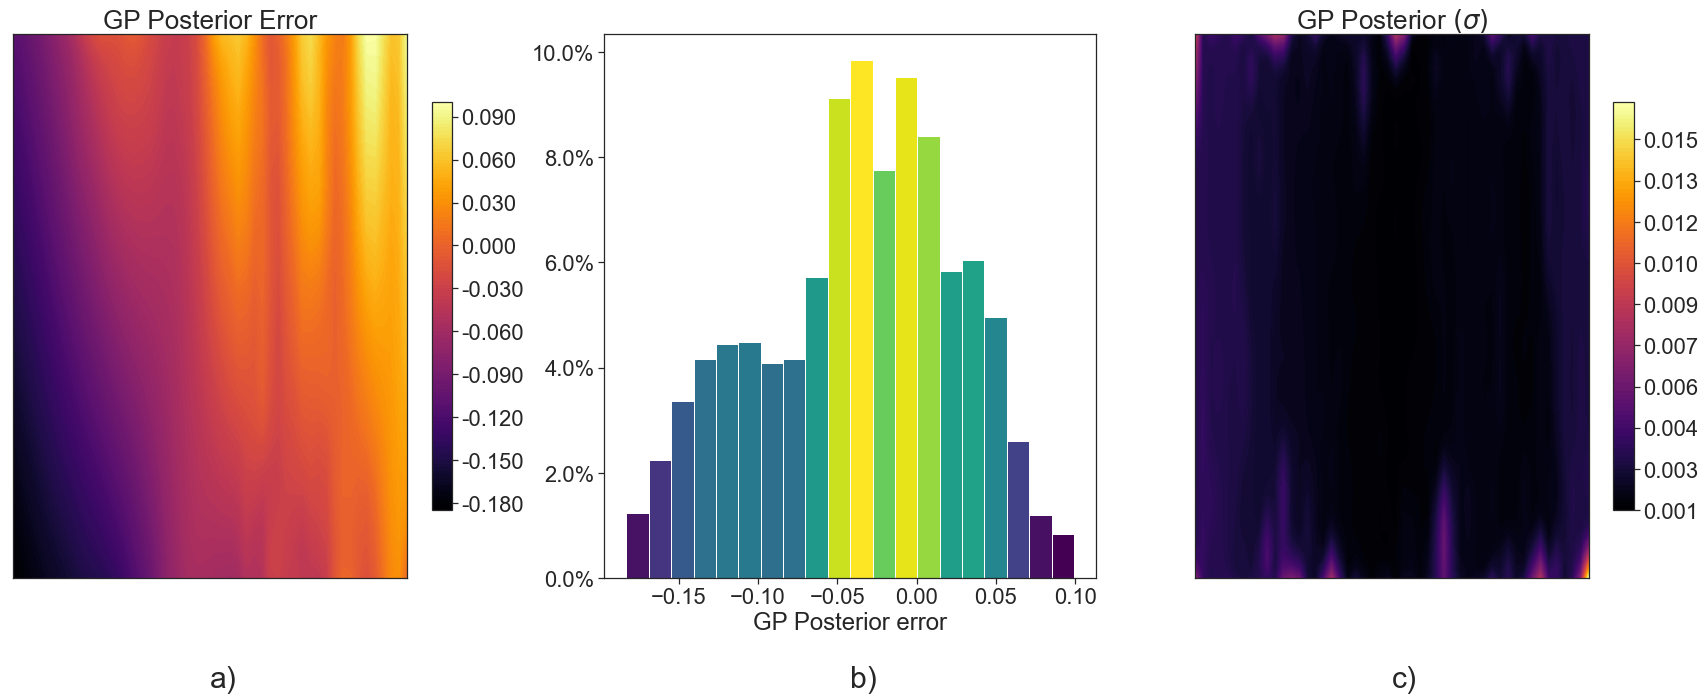

In [10]:
# Plot results
case.plot_posterior(savefile="exports/case1/prediction/")
case.plot_posterior_error(savefile="exports/case1/error/")

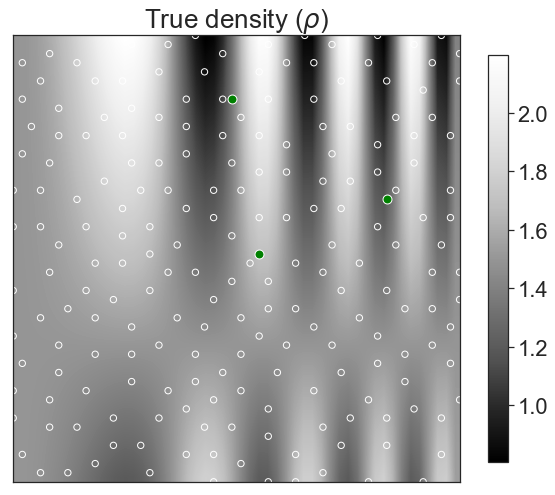

In [11]:
case.plot_sampling_pts_overlay(savefile="exports/case1_sampling_locs.jpg")